In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'lines.markersize': 10})

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import ttest_1samp
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d
from scipy.stats import iqr

from copy import deepcopy

import divebomb

import time
import pickle

import importlib

np.random.seed(0)

import Preprocessor
import Parameters
import HHMM
import Visualisor

In [2]:
print(expit([3.3403, 1.5665, 0.4267]))

def eta_2_ptm(eta):
    ptm = np.exp(eta)
    return (ptm.T/np.sum(ptm,1)).T

eta_2_ptm(np.array([[  0.    ,  -2.0691, -13.2605],
         [ -1.6902,   0.    ,  -3.1311],
         [-16.9396,  -1.2303,   0.    ]]))

[0.96578576 0.82728408 0.60508538]


array([[8.87862014e-01, 1.12136440e-01, 1.54661956e-06],
       [1.50211513e-01, 8.14231226e-01, 3.55572611e-02],
       [3.40324954e-08, 2.26128915e-01, 7.73871051e-01]])

In [3]:
FoVeDBA_mu = np.array([[34.98],[505.79],[9769.98]])
FoVeDBA_mu.flatten()

array([  34.98,  505.79, 9769.98])

# Load in the HMMs

In [40]:
#model = 'hhmm_FV'
#titl = 'CarHHMM-DFT'

#model = 'hhmm_FV_uncorr'
#titl = 'HHMM-DFT'

#model = 'hhmm_V'
#titl = 'CarHHMM'

model = 'hmm_FV'
titl = 'CarHMM-DFT'


rngs = {'hhmm_FV': range(1501,2001),
        'hhmm_FV_uncorr': range(501,1001),
        'hhmm_V': range(1001,1501),
        'hmm_FV': range(1,501)}

#date = '07_22_20'
#date = '08_20_20'
#date = '09_08_20'
#date = 'new_sim'
date = '07_06_2021'

hhmms = []
for dataset_num in rngs[model]:
    try:
        file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
        with open(file, 'rb') as f:
            hhmm = pickle.load(f)
            A = hhmm.SEs
            if A is None:
                print(file)
        hhmms.append(hhmm)
    except:
        print('../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num))

# Plot Empirical distribtuion
 - Compare with Fischer SEs

In [23]:
def make_2d_kde_theta(feature,theta0,hhmms,dive_type,N,include_corr=False,feature_name=''):
    
    # get mu and sigma and corr
    if dive_type == -1:
        mus = np.array([hhmm.theta[0][feature]['mu'] for hhmm in hhmms])
        mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

        sigs = np.array([hhmm.theta[0][feature]['sig'] for hhmm in hhmms])
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])

        corrs = expit(np.array([hhmm.theta[0][feature]['corr'] for hhmm in hhmms]))
        corrs_SE = np.array([hhmm.SEs[feature]['corr'] for hhmm in hhmms])
    
    else:
        mus = np.array([hhmm.theta[1][dive_type][feature]['mu'] for hhmm in hhmms])
        mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

        sigs = np.array([hhmm.theta[1][dive_type][feature]['sig'] for hhmm in hhmms])
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])

        corrs = expit(np.array([hhmm.theta[1][dive_type][feature]['corr'] for hhmm in hhmms]))
        corrs_SE = np.array([hhmm.SEs[feature]['corr'] for hhmm in hhmms])
    
    # get a 2-D histogram of these guys
    for i in range(N):

        xlim = [np.mean(mus[:,i])-3*np.std(mus[:,i]),np.mean(mus[:,i])+3*np.std(mus[:,i])]
        ylim = [np.mean(sigs[:,i])-3*np.std(sigs[:,i]),np.mean(sigs[:,i])+3*np.std(sigs[:,i])]
        zlim = [np.mean(corrs[:,i])-3*np.std(corrs[:,i]),np.mean(corrs[:,i])+3*np.std(corrs[:,i])]
        
        if theta0:
            xlim[0] = min(xlim[0],theta0['mu'][i])
            xlim[1] = max(xlim[1],theta0['mu'][i])
            ylim[0] = min(ylim[0],theta0['sig'][i])
            ylim[1] = max(ylim[1],theta0['sig'][i])
            zlim[0] = min(zlim[0],theta0['corr'][i])
            zlim[1] = max(zlim[1],theta0['corr'][i])
        
        if include_corr:
            fig, axs = plt.subplots(2,2,figsize = (6,6))

            plt.subplot(2,2,1)
            kernel = gaussian_kde([mus[:,i],corrs[:,i]])
            Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,zlim[0]:zlim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.imshow(np.rot90(Ztemp),extent = xlim + zlim, aspect='auto')
            plt.plot(theta0['mu'][i],theta0['corr'][i],'r*')
            c = plt.colorbar()
            c.set_label('Density')
            plt.xticks([])
            if dive_type == -1:
                plt.ylabel(r'$\hat \phi_%s^{(%d)}$' % (feature_name,i+1))
            else:
                plt.ylabel(r'$\hat \phi_%s^{*(\cdot,%d)}$' % (feature_name,i+1))

            fig.delaxes(axs[0,1])

            plt.subplot(2,2,3)
            kernel = gaussian_kde([mus[:,i],sigs[:,i]])
            Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,ylim[0]:ylim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.imshow(np.rot90(Ztemp),extent = xlim + ylim, aspect='auto')
            plt.plot(theta0['mu'][i],theta0['sig'][i],'r*')
            c = plt.colorbar()
            if dive_type == -1:
                plt.ylabel(r'$\hat \mu^{(%d)}$' % (i+1))
                plt.ylabel(r'$\hat \sigma^{(%d)}$' % (i+1))
            else:
                plt.xlabel(r'$\hat \mu_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
                plt.ylabel(r'$\hat \sigma_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
            
            plt.subplot(2,2,4)
            kernel = gaussian_kde([corrs[:,i],sigs[:,i]])
            Xtemp, Ytemp = np.mgrid[zlim[0]:zlim[1]:100j,ylim[0]:ylim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.imshow(np.rot90(Ztemp),extent = zlim + ylim, aspect='auto')
            plt.plot(theta0['corr'][i],theta0['sig'][i],'r*')
            c = plt.colorbar()
            c.set_label('Density')
            if dive_type == -1:
                plt.xlabel(r'$\hat \phi_%s^{(%d)}$' % (feature_name,i+1))
            else:
                plt.xlabel(r'$\hat \phi_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
            plt.yticks([])
            fig.suptitle(titl)
            

            
        else:
            
            kernel = gaussian_kde([mus[:,i],sigs[:,i]])
            Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,ylim[0]:ylim[1]:100j]
            positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
            Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
            plt.figure(figsize = (4,3))
            plt.imshow(np.rot90(Ztemp),extent = xlim + ylim, aspect='auto')
            if theta0:
                plt.plot(theta0['mu'][i],theta0['sig'][i],'r*')
            c = plt.colorbar()
            c.set_label('Density')
            plt.xlabel(r'$\hat \mu$')
            plt.ylabel(r'$\hat \sigma$')
            plt.title(titl)
            if dive_type == -1:
                plt.xlabel(r'$\hat \mu^{(%d)}$' % (i+1))
                plt.ylabel(r'$\hat \sigma^{(%d)}$' % (i+1))
            else:
                plt.xlabel(r'$\hat \mu_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
                plt.ylabel(r'$\hat \sigma_%s^{*(\cdot,%d)}$' % (feature_name,i+1))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig('../Plots/%s_MLE_density_%s_%d_%d.png'%(model,feature,dive_type,i),dpi=300)
        plt.show()
        
    print(r'$\hat \mu$ sample mean:', np.mean(mus,0))
    if theta0:
        print('Bias:', np.mean(mus,0) - np.array(theta0['mu']))
    print('Empirical Standard Error:', np.std(mus,0))
    print('Fischer Standard Error:',np.nanmedian(mus_SE,0))
    print('pm:',np.std(mus_SE,0))
    print('')

    print(r'$\sigma$ sample mean:', np.mean(sigs,0))
    if theta0:
        print('Bias:', np.mean(sigs,0) - np.array(theta0['sig']))
    print('Empirical Standard Error:', np.std(sigs,0))
    print('Fischer Standard Error:',np.nanmedian(sigs_SE,0))
    print('pm:',np.std(sigs_SE,0))
    print('')

    if include_corr:
        print(r'$\rho$ sample mean:', np.mean(corrs,0))
        if theta0:
            print('Bias:', np.mean(corrs,0) - np.array(theta0['corr']))
        print('Empirical Standard Error:', np.std(corrs,0))
        print('Fischer Standard Error:',np.nanmedian(corrs_SE,0))
        print('pm:',np.std(corrs_SE,0))
        print('')
        
    return


def make_2d_kde_gamma(G0,hhmms,dive_type,rownum):
    
    Gs = []
    SEs = []
    for hhmm in hhmms:
        if dive_type == -1:
            ptm = HHMM.eta_2_ptm(hhmm.eta[0])
            try:
                SE = hhmm.SEs['Gamma_coarse']
            except:
                print(hhmm.SEs)
            Gs.append(np.array([ptm[0,1],ptm[1,0]]))
            SEs.append(np.array([SE[0,1],SE[1,0]]))
        else:
            ptm = HHMM.eta_2_ptm(hhmm.eta[1][dive_type])
            SE = hhmm.SEs['Gamma_fine'][dive_type]
            colnums = [0,1,2]
            colnums.remove(rownum)
            Gs.append(np.array([ptm[rownum,colnums[0]],
                                ptm[rownum,colnums[1]]]))
            SEs.append(np.array([SE[rownum,colnums[0]],
                                 SE[rownum,colnums[1]]]))

    Gs = np.array(Gs)
    
    xlim = [np.mean(Gs[:,0])-3*np.std(Gs[:,0]),np.mean(Gs[:,0])+3*np.std(Gs[:,0])]
    ylim = [np.mean(Gs[:,1])-3*np.std(Gs[:,1]),np.mean(Gs[:,1])+3*np.std(Gs[:,1])]
    
    if G0:
        xlim[0] = max(min(xlim[0],G0[0]),0.0)
        xlim[1] = min(max(xlim[1],G0[0]),1.0)
        ylim[0] = max(min(ylim[0],G0[1]),0.0)
        ylim[1] = min(max(ylim[1],G0[1]),1.0)
    
    print(Gs)
    
    kernel = gaussian_kde([Gs[:,0],Gs[:,1]])
    Xtemp, Ytemp = np.mgrid[xlim[0]:xlim[1]:100j,ylim[0]:ylim[1]:100j]
    positions = np.vstack([Xtemp.ravel(), Ytemp.ravel()])
    Ztemp = np.reshape(kernel.pdf(positions).T, Xtemp.shape)
    plt.figure(figsize=(4,3))
    plt.imshow(np.rot90(Ztemp),extent = xlim + ylim, aspect='auto')
    if G0:
        plt.plot(G0[0],G0[1],'r*')
    c = plt.colorbar()
    c.set_label('Density')
    plt.xlabel('$\Gamma_{12}$')
    plt.ylabel('$\Gamma_{21}$')
    if dive_type == -1:
        plt.title(titl)
        plt.xlabel('$\hat \Gamma_{12}$')
        plt.ylabel('$\hat \Gamma_{21}$')
    else:
        plt.title(titl)
        plt.xlabel('$\hat \Gamma^{*(%d)}_{%d,%d}$' % (dive_type+1,rownum,colnums[0]))
        plt.ylabel('$\hat \Gamma^{*(%d)}_{%d,%d}$' % (dive_type+1,rownum,colnums[1]))
        
    plt.tight_layout()
    plt.savefig('../Plots/%s_Gamma_density_%d_row_%d.png'%(model,dive_type,rownum),dpi=300)
    plt.show()

    print('Sample Mean:', np.mean(Gs,0))
    if G0:
        print('Bias:', np.mean(Gs,0) - G0)
    print('Empirical Standard Error: \n', np.std(Gs,0))
    print('Fischer Standard Error: \n', np.nanmedian(SEs,0))
    print('pm:', np.std(SEs,0))
    
    return

# Consider $\hat \Gamma$

In [24]:
for i in range(500):
    try:
        if hhmms[i].SEs is None:
            hhmms.pop(i)
        elif np.any(np.isnan(hhmms[i].eta[0])):
            hhmms.pop(i)
        elif np.any(np.isnan(hhmms[i].eta[1][0])):
            hhmms.pop(i)
        elif np.any(np.isnan(hhmms[i].eta[1][1])):
            hhmms.pop(i)
    except IndexError:
        break

In [26]:
# make Gamma
if 'hhmm' in model:
    
    # Gamma Coarse
    G0 = [0.15,0.91]
    make_2d_kde_gamma(G0,hhmms,-1,-1)
    
    # Gamma Fine 0
    G0 = [0.32,0.05]
    make_2d_kde_gamma(G0,hhmms,0,0)
    G0 = [0.32,0.05]
    make_2d_kde_gamma(G0,hhmms,0,1)
    G0 = [0.32,0.05]
    make_2d_kde_gamma(G0,hhmms,0,2)
    
    # Gamma Fine 1
    G0 = [0.14,0.15]
    make_2d_kde_gamma(G0,hhmms,1,0)
    G0 = [0.14,0.15]
    make_2d_kde_gamma(G0,hhmms,1,1)
    G0 = [0.14,0.15]
    make_2d_kde_gamma(G0,hhmms,1,2)
    
else:
    
    G0 = []
    make_2d_kde_gamma(G0,hhmms,0,0)
    make_2d_kde_gamma(G0,hhmms,0,1)
    make_2d_kde_gamma(G0,hhmms,0,2)

[[0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]
 [0.18       0.        ]


LinAlgError: singular matrix

# Consider $\hat \Theta$ Coarse

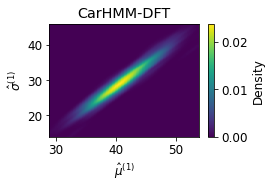

$\hat \mu$ sample mean: [41.43432343]
Empirical Standard Error: [4.15440632]
Fischer Standard Error: [1.98557654]
pm: [0.25873001]

$\sigma$ sample mean: [29.98677654]
Empirical Standard Error: [5.35839769]
Fischer Standard Error: [1.94581197]
pm: [0.32989202]



In [27]:
# dive duration
if 'hhmm' in model:
    theta0 = {'mu':[27.27,127.07],'sig':[10.91,64.06],'corr':[0,0]}
    N = 2
else:
    sig = np.array([np.sqrt(np.mean(np.array([5,50])**2) + np.var(np.array([20,80])))])
    theta0 = None
    #theta0 = {'mu':[],'sig':[],'corr':[]}
    N = 1
    
make_2d_kde_theta('dive_duration',theta0,hhmms,-1,N,include_corr=False,feature_name='Y')

# Consider $\hat \theta^*$ Fine

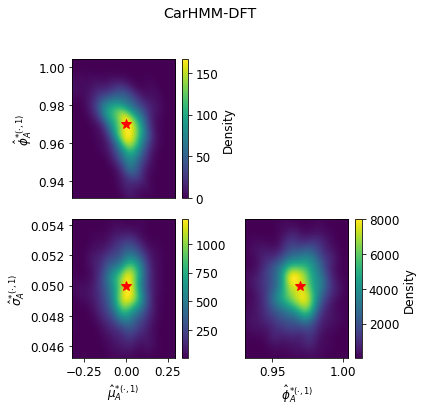

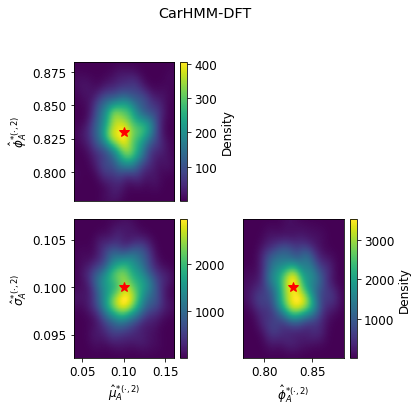

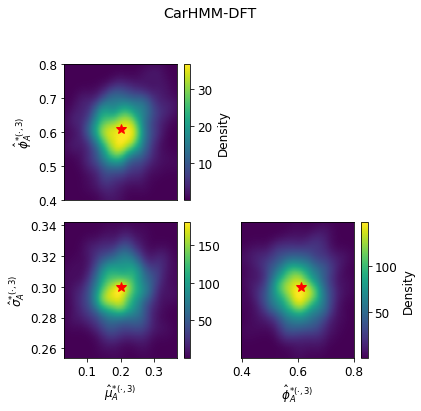

$\hat \mu$ sample mean: [-0.01581752  0.10047039  0.19982256]
Bias: [-0.01581752  0.00047039 -0.00017744]
Empirical Standard Error: [0.10271994 0.02008284 0.05585629]
Fischer Standard Error: [0.06616146 0.01934032 0.05310701]
pm: [0.05952496 0.00224523 0.01086384]

$\sigma$ sample mean: [0.04978617 0.0998143  0.29766918]
Bias: [-0.00021383 -0.0001857  -0.00233082]
Empirical Standard Error: [0.00152454 0.00243657 0.01473587]
Fischer Standard Error: [0.00152014 0.00239194 0.01511891]
pm: [0.00017672 0.00012947 0.00147325]

$\rho$ sample mean: [0.96753547 0.83034189 0.59958774]
Bias: [-0.00246453  0.00034189 -0.01041226]
Empirical Standard Error: [0.01218991 0.01734029 0.0668557 ]
Fischer Standard Error: [0.01013899 0.01671006 0.06433942]
pm: [0.00232102 0.00121868 0.00778258]



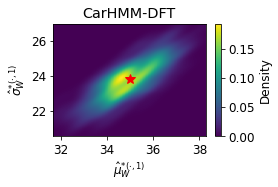

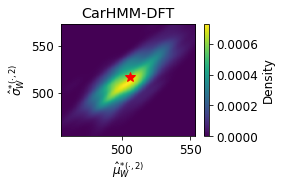

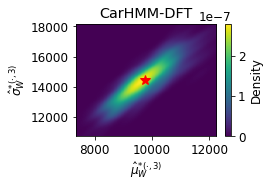

$\hat \mu$ sample mean: [  34.96258333  504.26211149 9796.54818892]
Bias: [-1.74166723e-02 -1.52788851e+00  2.65681889e+01]
Empirical Standard Error: [  1.10566811  16.47551461 815.79450257]
Fischer Standard Error: [  0.65914043   9.76402243 331.58884598]
pm: [0.07554376 0.60984361        nan]

$\sigma$ sample mean: [   23.75703125   513.54220815 14432.2117453 ]
Bias: [ -0.09296875  -3.13779185 -30.3382547 ]
Empirical Standard Error: [1.06969839e+00 1.98388984e+01 1.24287258e+03]
Fischer Standard Error: [  0.65321569  11.45728162 428.07935942]
pm: [0.07857911 0.69854657        nan]



In [28]:
# acceleration
N_star = 3
theta0 = {'mu':[0.0,0.1,0.2],'sig':[0.05,0.1,0.3],'corr':[0.97,0.83,0.61]}
dive_type = 0

if 'uncorr' in model:
    make_2d_kde_theta('A',theta0,hhmms,dive_type,N_star,include_corr=False,feature_name='A')
else:
    make_2d_kde_theta('A',theta0,hhmms,dive_type,N_star,include_corr=True,feature_name='A')

if 'FV' in model:
    # FoVeDBA
    #F_mus0 = np.array([sum([5.0/n for n in range(2,12)]),
    #                   300 + sum([5.0/n for n in range(4,12)])])
    #F_sigs0 = np.sqrt(F_mus0)
    theta0 = {'mu':[34.98,505.79,9769.98],'sig':[23.85,516.68,14462.55],'corr':[0,0,0]}
    dive_type = 0
    make_2d_kde_theta('FoVeDBA',theta0,hhmms,dive_type,N_star,include_corr=False,feature_name='W')

# Get percentage of time in right dive and subdive states

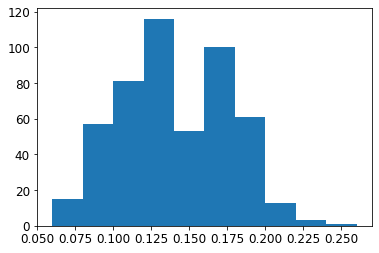

0.14206
0.03314146043855039


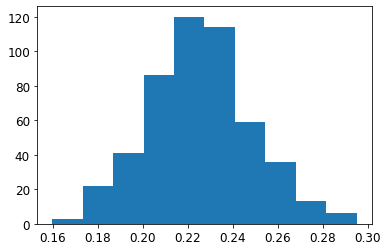

0.22540554148714137
0.022830857034782825


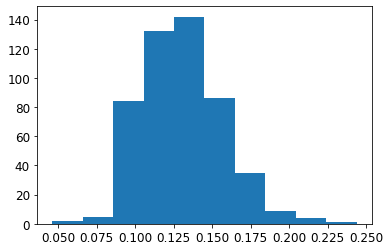

0.13053079802248013
0.026700846617361534


In [29]:
def acc(CM):
    return (CM[0,0]+CM[1,1])/np.sum(CM)

# get coarse accuracy
accuracies_coarse = [1.0-acc(hhmm.CM[0]) for hhmm in hhmms]
plt.hist(accuracies_coarse)
plt.show()
print(np.mean(accuracies_coarse))
print(np.std(accuracies_coarse))

accuracies_fine0 = [1.0-acc(hhmm.CM[1][0]) for hhmm in hhmms]
plt.hist(accuracies_fine0)
plt.show()
print(np.mean(accuracies_fine0))
print(np.std(accuracies_fine0))

accuracies_fine1 = [1.0-acc(hhmm.CM[1][1]) for hhmm in hhmms]
plt.hist(accuracies_fine1)
plt.show()
print(np.mean(accuracies_fine1))
print(np.std(accuracies_fine1))

# Get time to train

In [30]:
hhmm.theta

[{'dive_duration': {'mu': array([36.91510952]),
   'sig': array([22.57843536]),
   'corr': array([-10.])}},
 [{'FoVeDBA': {'mu': array([  33.61034449,  531.86110981, 8488.81065153]),
    'sig': array([   22.68064396,   546.54390538, 12670.47573951]),
    'corr': array([-10., -10., -10.])},
   'A': {'mu': array([0.13062485, 0.09060784, 0.25892013]),
    'sig': array([0.0460392 , 0.10312498, 0.29719275]),
    'corr': array([3.75708094, 1.58098707, 0.37354932])}}]]

284.5992637671471
63.55932283097879


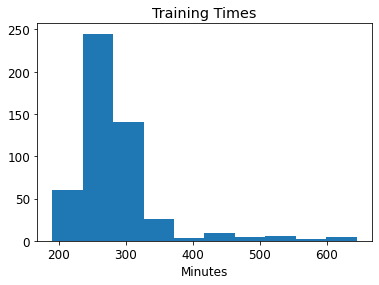

In [31]:
times = [hhmm.train_time/60.0 for hhmm in hhmms]
plt.hist(times)
plt.title('Training Times')
plt.xlabel('Minutes')
print(np.mean(times))
print(np.std(times))

# Make Table for Report

In [42]:
def make_table_dd():
    
    feature = 'dive_duration'
    
    est_mus = []
    est_sigs = []
    bias_mus = []
    bias_sigs = []
    ESE_mus = []
    ESE_sigs = []
    FSE_mus = []
    FSE_mus_SE = []
    FSE_sigs = []
    FSE_sigs_SE = []
    p_mus = []
    p_sigs = []
    
    for model in ['hmm_FV','hhmm_FV_uncorr','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
                
        #if model == 'hhmm_FV':
        #    hhmms.pop(411) 
                
        # get estimates
        mus = np.array([hhmm.theta[0][feature]['mu'] for hhmm in hhmms])
        est_mus.append(np.mean(mus,0))
        try:
            mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])
        except:
            print(hhmms[1].SEs)
            print(feature)

        sigs = np.array([hhmm.theta[0][feature]['sig'] for hhmm in hhmms])
        est_sigs.append(np.mean(sigs,0))
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])
        
        # get biases a p-values
        if model == 'hmm_FV':
            sig0 = np.sqrt(np.mean(np.array([5,50])**2) + np.var(np.array([20,80])))
            bias_mus.append(est_mus[-1] - np.array([50]))
            bias_sigs.append(est_sigs[-1] - np.array([sig0]))
            p_mus.append(ttest_1samp(mus,[50],axis=0,nan_policy='omit')[1])
            p_sigs.append(ttest_1samp(sigs,[sig0],axis=0,nan_policy='omit')[1])
        else:
            bias_mus.append(est_mus[-1] - np.array([25.68,104.6]))
            bias_sigs.append(est_sigs[-1] - np.array([9.57,64.7]))
            p_mus.append(ttest_1samp(mus,[25.68,104.6],axis=0,nan_policy='omit')[1])
            p_sigs.append(ttest_1samp(sigs,[9.57,64.7],axis=0,nan_policy='omit')[1])
            
        # get empirical standard errors
        ESE_mus.append(np.std(mus,0))
        ESE_sigs.append(np.std(sigs,0))
        
        # get Fischer Standard Errors
        FSE_mus.append(np.nanmedian(mus_SE,0))
        FSE_mus_SE.append(iqr(mus_SE,0,nan_policy='omit'))
        FSE_sigs.append(np.nanmedian(sigs_SE,0))
        FSE_sigs_SE.append(iqr(sigs_SE,0,nan_policy='omit'))
    
    table = r'''
\begin{table}[]
\label{table:dive_duration}
\centering
\caption{Estimates and standard errors of parameters for dive duration distribution for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.9}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Dive Type} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias}   & \multicolumn{1}{c}{Empirical SE}   & \multicolumn{1}{c}{Observed Fischer SE}     \\ \hline
\multirow{4}{*}{CarHMM-DFT} & \multirow{2}{*}{$\mu$}        & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & ---                           & ---                            & ---                        & ---                                & ---                                         \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & ---                           & ---                            & ---                        & ---                                & ---                                         \\ \hline
\multirow{4}{*}{HHMM-DFT}   & \multirow{2}{*}{$\mu$}        & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{4}{*}{CarHHMM}    & \multirow{2}{*}{$\mu$}        & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{4}{*}{CarHHMM-DFT}& \multirow{2}{*}{$\mu$}        & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma$}     & 1                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                             & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             
\end{tabular}
}
\end{table}
    ''' % (
    est_mus[0][0],bias_mus[0][0],p_mus[0][0],ESE_mus[0][0],FSE_mus[0][0],FSE_mus_SE[0][0],
    est_sigs[0][0],bias_sigs[0][0],p_sigs[0][0],ESE_sigs[0][0],FSE_sigs[0][0],FSE_sigs_SE[0][0],
        
    est_mus[1][0],bias_mus[1][0],p_mus[1][0],ESE_mus[1][0],FSE_mus[1][0],FSE_mus_SE[1][0],
    est_mus[1][1],bias_mus[1][1],p_mus[1][1],ESE_mus[1][1],FSE_mus[1][1],FSE_mus_SE[1][1],
    est_sigs[1][0],bias_sigs[1][0],p_sigs[1][0],ESE_sigs[1][0],FSE_sigs[1][0],FSE_sigs_SE[1][0],
    est_sigs[1][1],bias_sigs[1][1],p_sigs[1][1],ESE_sigs[1][1],FSE_sigs[1][1],FSE_sigs_SE[1][1],
        
    est_mus[2][0],bias_mus[2][0],p_mus[2][0],ESE_mus[2][0],FSE_mus[2][0],FSE_mus_SE[2][0],
    est_mus[2][1],bias_mus[2][1],p_mus[2][1],ESE_mus[2][1],FSE_mus[2][1],FSE_mus_SE[2][1],
    est_sigs[2][0],bias_sigs[2][0],p_sigs[2][0],ESE_sigs[2][0],FSE_sigs[2][0],FSE_sigs_SE[2][0],
    est_sigs[2][1],bias_sigs[2][1],p_sigs[2][1],ESE_sigs[2][1],FSE_sigs[2][1],FSE_sigs_SE[2][1],
        
    est_mus[3][0],bias_mus[3][0],p_mus[3][0],ESE_mus[3][0],FSE_mus[3][0],FSE_mus_SE[3][0],
    est_mus[3][1],bias_mus[3][1],p_mus[3][1],ESE_mus[3][1],FSE_mus[3][1],FSE_mus_SE[3][1],
    est_sigs[3][0],bias_sigs[3][0],p_sigs[3][0],ESE_sigs[3][0],FSE_sigs[3][0],FSE_sigs_SE[3][0],
    est_sigs[3][1],bias_sigs[3][1],p_sigs[3][1],ESE_sigs[3][1],FSE_sigs[3][1],FSE_sigs_SE[3][1],
    )
    return table

print(make_table_dd())

../../Params/sims/07_06_2021/hhmm_V_0_1005
../../Params/sims/07_06_2021/hhmm_V_0_1011
../../Params/sims/07_06_2021/hhmm_V_0_1019
../../Params/sims/07_06_2021/hhmm_V_0_1021
../../Params/sims/07_06_2021/hhmm_V_0_1022
../../Params/sims/07_06_2021/hhmm_V_0_1025
../../Params/sims/07_06_2021/hhmm_V_0_1032
../../Params/sims/07_06_2021/hhmm_V_0_1033
../../Params/sims/07_06_2021/hhmm_V_0_1035
../../Params/sims/07_06_2021/hhmm_V_0_1036
../../Params/sims/07_06_2021/hhmm_V_0_1037
../../Params/sims/07_06_2021/hhmm_V_0_1064
../../Params/sims/07_06_2021/hhmm_V_0_1069
../../Params/sims/07_06_2021/hhmm_V_0_1070
../../Params/sims/07_06_2021/hhmm_V_0_1071
../../Params/sims/07_06_2021/hhmm_V_0_1088
../../Params/sims/07_06_2021/hhmm_V_0_1089
../../Params/sims/07_06_2021/hhmm_V_0_1110
../../Params/sims/07_06_2021/hhmm_V_0_1111
../../Params/sims/07_06_2021/hhmm_V_0_1114
../../Params/sims/07_06_2021/hhmm_V_0_1121
../../Params/sims/07_06_2021/hhmm_V_0_1123
../../Params/sims/07_06_2021/hhmm_V_0_1134
../../Param

In [43]:
def make_table_A():
    
    feature = 'A'
    
    est_mus = []
    est_sigs = []
    est_corrs = []
    bias_mus = []
    bias_sigs = []
    bias_corrs = []
    ESE_mus = []
    ESE_sigs = []
    ESE_corrs = []
    FSE_mus = []
    FSE_mus_SE = []
    FSE_sigs = []
    FSE_sigs_SE = []
    FSE_corrs = []
    FSE_corrs_SE = []
    p_mus = []
    p_sigs = []
    p_corrs = []
    
    for model in ['hmm_FV','hhmm_FV_uncorr','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
                    
        if model == 'hhmm_FV':
            hhmms.pop(411) 
            
        # get estimates
        mus = np.array([hhmm.theta[1][0][feature]['mu'] for hhmm in hhmms])
        est_mus.append(np.mean(mus,0))
        mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

        sigs = np.array([hhmm.theta[1][0][feature]['sig'] for hhmm in hhmms])
        est_sigs.append(np.mean(sigs,0))
        sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])
        
        corrs = expit(np.array([hhmm.theta[1][0][feature]['corr'] for hhmm in hhmms]))
        est_corrs.append(np.mean(corrs,0))
        corrs_SE = np.array([hhmm.SEs[feature]['corr'] for hhmm in hhmms])
        
        # get biases
        bias_mus.append(est_mus[-1] - np.array([0,0]))
        p_mus.append(ttest_1samp(mus,[0,0],axis=0,nan_policy='omit')[1])
        bias_sigs.append(est_sigs[-1] - np.array([0.05,0.1]))
        p_sigs.append(ttest_1samp(sigs,[0.05,0.1],axis=0,nan_policy='omit')[1])
        if model != 'hhmm_FV_uncorr':
            bias_corrs.append(est_corrs[-1] - np.array([0.99,0.95]))
            p_corrs.append(ttest_1samp(corrs,[0.99,0.95],axis=0,nan_policy='omit')[1])
        else:
            bias_corrs.append([])
            p_corrs.append([])

        # get empirical standard errors
        ESE_mus.append(np.std(mus,0))
        ESE_sigs.append(np.std(sigs,0))
        ESE_corrs.append(np.std(corrs,0))
        
        # get Fischer Standard Errors
        FSE_mus.append(np.nanmedian(mus_SE,0))
        FSE_mus_SE.append(iqr(mus_SE,0,nan_policy='omit'))
        FSE_sigs.append(np.nanmedian(sigs_SE,0))
        FSE_sigs_SE.append(iqr(sigs_SE,0,nan_policy='omit'))
        FSE_corrs.append(np.nanmedian(corrs_SE,0))
        FSE_corrs_SE.append(iqr(corrs_SE,0,nan_policy='omit'))
        
    
    table = r'''
\begin{table}[]
\centering
\caption{Estimates and standard errors of parameters for $A^*_{t,t^*}$ for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.7}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias}   & \multicolumn{1}{c}{Empirical SE}   & \multicolumn{1}{c}{Observed Fischer SE}        \\ \hline
\multirow{6}{*}{CarHMM-DFT} & \multirow{2}{*}{$\mu_A^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma_A^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ 
                            & \multirow{2}{*}{$\phi_A^*$}   & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{6}{*}{HHMM-DFT}   & \multirow{2}{*}{$\mu_A^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma_A^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ 
                            & \multirow{2}{*}{$\phi_A^*$}   & 1                                & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 2                                & ------                         & ------                     & ------                             & ------                                      \\ \hline
\multirow{6}{*}{CarHHMM}    & \multirow{2}{*}{$\mu_A^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma_A^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ 
                            & \multirow{2}{*}{$\phi_A^*$}   & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{6}{*}{CarHHMM-DFT}& \multirow{2}{*}{$\mu_A^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma_A^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ 
                            & \multirow{2}{*}{$\phi_A^*$}   & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\end{tabular}
}
\end{table}
    ''' % (
    est_mus[0][0],bias_mus[0][0],p_mus[0][0],ESE_mus[0][0],FSE_mus[0][0],FSE_mus_SE[0][0],
    est_mus[0][1],bias_mus[0][1],p_mus[0][1],ESE_mus[0][1],FSE_mus[0][1],FSE_mus_SE[0][1],
    est_sigs[0][0],bias_sigs[0][0],p_sigs[0][0],ESE_sigs[0][0],FSE_sigs[0][0],FSE_sigs_SE[0][0],
    est_sigs[0][1],bias_sigs[0][1],p_sigs[0][1],ESE_sigs[0][1],FSE_sigs[0][1],FSE_sigs_SE[0][1],
    est_corrs[0][0],bias_corrs[0][0],p_corrs[0][0],ESE_corrs[0][0],FSE_corrs[0][0],FSE_corrs_SE[0][0],
    est_corrs[0][1],bias_corrs[0][1],p_corrs[0][1],ESE_corrs[0][1],FSE_corrs[0][1],FSE_corrs_SE[0][1],
        
    est_mus[1][0],bias_mus[1][0],p_mus[1][0],ESE_mus[1][0],FSE_mus[1][0],FSE_mus_SE[1][0],
    est_mus[1][1],bias_mus[1][1],p_mus[1][1],ESE_mus[1][1],FSE_mus[1][1],FSE_mus_SE[1][1],
    est_sigs[1][0],bias_sigs[1][0],p_sigs[1][0],ESE_sigs[1][0],FSE_sigs[1][0],FSE_sigs_SE[1][0],
    est_sigs[1][1],bias_sigs[1][1],p_sigs[1][1],ESE_sigs[1][1],FSE_sigs[1][1],FSE_sigs_SE[1][1],
        
    est_mus[2][0],bias_mus[2][0],p_mus[2][0],ESE_mus[2][0],FSE_mus[2][0],FSE_mus_SE[2][0],
    est_mus[2][1],bias_mus[2][1],p_mus[2][1],ESE_mus[2][1],FSE_mus[2][1],FSE_mus_SE[2][1],
    est_sigs[2][0],bias_sigs[2][0],p_sigs[2][0],ESE_sigs[2][0],FSE_sigs[2][0],FSE_sigs_SE[2][0],
    est_sigs[2][1],bias_sigs[2][1],p_sigs[2][1],ESE_sigs[2][1],FSE_sigs[2][1],FSE_sigs_SE[2][1],
    est_corrs[2][0],bias_corrs[2][0],p_corrs[2][0],ESE_corrs[2][0],FSE_corrs[2][0],FSE_corrs_SE[2][0],
    est_corrs[2][1],bias_corrs[2][1],p_corrs[2][1],ESE_corrs[2][1],FSE_corrs[2][1],FSE_corrs_SE[2][1],
        
    est_mus[3][0],bias_mus[3][0],p_mus[3][0],ESE_mus[3][0],FSE_mus[3][0],FSE_mus_SE[3][0],
    est_mus[3][1],bias_mus[3][1],p_mus[3][1],ESE_mus[3][1],FSE_mus[3][1],FSE_mus_SE[3][1],
    est_sigs[3][0],bias_sigs[3][0],p_sigs[3][0],ESE_sigs[3][0],FSE_sigs[3][0],FSE_sigs_SE[3][0],
    est_sigs[3][1],bias_sigs[3][1],p_sigs[3][1],ESE_sigs[3][1],FSE_sigs[3][1],FSE_sigs_SE[3][1],
    est_corrs[3][0],bias_corrs[3][0],p_corrs[3][0],ESE_corrs[3][0],FSE_corrs[3][0],FSE_corrs_SE[3][0],
    est_corrs[3][1],bias_corrs[3][1],p_corrs[3][1],ESE_corrs[3][1],FSE_corrs[3][1],FSE_corrs_SE[3][1],
    )
    return table

print(make_table_A())

ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [48]:
def make_table_FoVeDBA():
    
    #F_mus0 = np.array([sum([5.0/n for n in range(2,12)]),
    #                   300 + sum([5.0/n for n in range(4,12)])])
    #F_sigs0 = np.sqrt(F_mus0)
    
    F_mus0 = np.array([23.34,301.2])
    F_sigs0 = np.array([12.95,330.1])
    
    feature = 'FoVeDBA'
    
    est_mus = []
    est_sigs = []
    bias_mus = []
    bias_sigs = []
    ESE_mus = []
    ESE_sigs = []
    FSE_mus = []
    FSE_mus_SE = []
    FSE_sigs = []
    FSE_sigs_SE = []
    p_mus = []
    p_sigs = []
    
    for model in ['hmm_FV','hhmm_FV_uncorr','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
                
        if model == 'hhmm_FV':
            hhmms.pop(411) 
            
        # get estimates
        if model != 'hhmm_V':
            mus = np.array([hhmm.theta[1][0][feature]['mu'] for hhmm in hhmms])
            est_mus.append(np.mean(mus,0))
            mus_SE = np.array([hhmm.SEs[feature]['mu'] for hhmm in hhmms])

            sigs = np.array([hhmm.theta[1][0][feature]['sig'] for hhmm in hhmms])
            est_sigs.append(np.mean(sigs,0))
            sigs_SE = np.array([hhmm.SEs[feature]['sig'] for hhmm in hhmms])

            # get biases
            bias_mus.append(est_mus[-1] - F_mus0)
            bias_sigs.append(est_sigs[-1] - F_sigs0)
            
            # get p-values
            p_mus.append(ttest_1samp(mus,F_mus0,axis=0,nan_policy='omit')[1])
            p_sigs.append(ttest_1samp(sigs,F_sigs0,axis=0,nan_policy='omit')[1])
            
            # get empirical standard errors
            ESE_mus.append(np.std(mus,0))
            ESE_sigs.append(np.std(sigs,0))

            # get Fischer Standard Errors
            FSE_mus.append(np.nanmedian(mus_SE,0))
            FSE_mus_SE.append(iqr(mus_SE,0,nan_policy='omit'))
            FSE_sigs.append(np.nanmedian(sigs_SE,0))
            FSE_sigs_SE.append(iqr(sigs_SE,0,nan_policy='omit'))
    
    table = r'''
\begin{table}
\label{table:FoVeDBA}
\centering
\caption{Estimates and standard errors of parameters for $W^*_{t,t^*}$ for all four models. All reported values are averages, except for the Fisher observed standard error, which are medians. $\pm$ refers to the IQR.}
\scalebox{0.8}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias}   & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}       \\ \hline
\multirow{4}{*}{CarHMM-DFT} & \multirow{2}{*}{$\mu_W^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma_W^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{4}{*}{HHMM-DFT}   & \multirow{2}{*}{$\mu_W^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma_W^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\ \hline
\multirow{4}{*}{CarHHMM}    & \multirow{2}{*}{$\mu_W^*$}    & 1                                & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 2                                & ------                         & ------                     & ------                             & ------                                      \\
                            & \multirow{2}{*}{$\sigma_W^*$} & 1                                & ------                         & ------                     & ------                             & ------                                      \\
                            &                               & 2                                & ------                         & ------                     & ------                             & ------                                      \\ \hline
\multirow{4}{*}{CarHHMM-DFT}& \multirow{2}{*}{$\mu_W^*$}    & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            & \multirow{2}{*}{$\sigma_W^*$} & 1                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             \\
                            &                               & 2                                & $%.3f$                         & $%.3f$ $(p=%.3f)$          & $%.3f$                             & $%.3f \pm %.3f$                             
\end{tabular}
}
\end{table}
    ''' % (
    est_mus[0][0],bias_mus[0][0],p_mus[0][0],ESE_mus[0][0],FSE_mus[0][0],FSE_mus_SE[0][0],
    est_mus[0][1],bias_mus[0][1],p_mus[0][1],ESE_mus[0][1],FSE_mus[0][1],FSE_mus_SE[0][1],
    est_sigs[0][0],bias_sigs[0][0],p_sigs[0][0],ESE_sigs[0][0],FSE_sigs[0][0],FSE_sigs_SE[0][0],
    est_sigs[0][1],bias_sigs[0][1],p_sigs[0][1],ESE_sigs[0][1],FSE_sigs[0][1],FSE_sigs_SE[0][1],
    
    est_mus[1][0],bias_mus[1][0],p_mus[1][0],ESE_mus[1][0],FSE_mus[1][0],FSE_mus_SE[1][0],
    est_mus[1][1],bias_mus[1][1],p_mus[1][1],ESE_mus[1][1],FSE_mus[1][1],FSE_mus_SE[1][1],
    est_sigs[1][0],bias_sigs[1][0],p_sigs[1][0],ESE_sigs[1][0],FSE_sigs[1][0],FSE_sigs_SE[1][0],
    est_sigs[1][1],bias_sigs[1][1],p_sigs[1][1],ESE_sigs[1][1],FSE_sigs[1][1],FSE_sigs_SE[1][1],
        
    est_mus[2][0],bias_mus[2][0],p_mus[2][0],ESE_mus[2][0],FSE_mus[2][0],FSE_mus_SE[2][0],
    est_mus[2][1],bias_mus[2][1],p_mus[2][1],ESE_mus[2][1],FSE_mus[2][1],FSE_mus_SE[2][1],
    est_sigs[2][0],bias_sigs[2][0],p_sigs[2][0],ESE_sigs[2][0],FSE_sigs[2][0],FSE_sigs_SE[2][0],
    est_sigs[2][1],bias_sigs[2][1],p_sigs[2][1],ESE_sigs[2][1],FSE_sigs[2][1],FSE_sigs_SE[2][1]
    )
    return table
print(make_table_FoVeDBA())

../../Params/new_sim/hmm_FV_0_77
../../Params/new_sim/hhmm_FV_uncorr_0_175
../../Params/new_sim/hhmm_FV_uncorr_0_315
../../Params/new_sim/hhmm_FV_uncorr_0_338
../../Params/new_sim/hhmm_V_0_57
../../Params/new_sim/hhmm_V_0_61
../../Params/new_sim/hhmm_V_0_83
../../Params/new_sim/hhmm_V_0_86
../../Params/new_sim/hhmm_V_0_125
../../Params/new_sim/hhmm_V_0_136
../../Params/new_sim/hhmm_V_0_147
../../Params/new_sim/hhmm_V_0_201
../../Params/new_sim/hhmm_V_0_238
../../Params/new_sim/hhmm_V_0_272
../../Params/new_sim/hhmm_V_0_284
../../Params/new_sim/hhmm_V_0_294
../../Params/new_sim/hhmm_V_0_321
../../Params/new_sim/hhmm_V_0_356
../../Params/new_sim/hhmm_V_0_404
../../Params/new_sim/hhmm_V_0_421
../../Params/new_sim/hhmm_V_0_488
../../Params/new_sim/hhmm_V_0_498
../../Params/new_sim/hhmm_V_0_499
../../Params/new_sim/hhmm_FV_0_315
../../Params/new_sim/hhmm_FV_0_338
../../Params/new_sim/hhmm_FV_0_425

\begin{table}
\label{table:FoVeDBA}
\centering
\caption{Estimates and standard errors of para

In [44]:
def make_table_Gamma():
    
    feature = 'FoVeDBA'
    
    est_G0 = []
    est_G10 = []
    est_G11 = []
    bias_G0 = []
    bias_G10 = []
    bias_G11 = []
    ESE_G0 = []
    ESE_G10 = []
    ESE_G11 = []
    FSE_G0 = []
    FSE_G10 = []
    FSE_G11 = []
    FSE_G0_SE = []
    FSE_G10_SE = []
    FSE_G11_SE = []
    p0 = []
    p10 = []
    p11 = []
    
    for model in ['hhmm_FV_uncorr','hmm_FV','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
                
        if model == 'hhmm_FV':
            hhmms.pop(411) 
                
        G0 = []
        SE0 = []
        G10 = []
        SE10 = []
        G11 = []
        SE11 = []
        
        for hhmm in hhmms:
            if model != 'hmm_FV':
                
                # coarse
                ptm = HHMM.eta_2_ptm(hhmm.eta[0])
                SE = hhmm.SEs['Gamma_coarse']
                G0.append(np.array([ptm[0,1],ptm[1,0]]))
                SE0.append(np.array([SE[0,1],SE[1,0]]))
                
                # fine
                ptm = HHMM.eta_2_ptm(hhmm.eta[1][1])
                SE = hhmm.SEs['Gamma_fine'][1]
                G11.append(np.array([ptm[0,1],ptm[1,0]]))
                SE11.append(np.array([SE[0,1],SE[1,0]]))
            
            # fine for both HMM and HHMM
            ptm = HHMM.eta_2_ptm(hhmm.eta[1][0])
            SE = hhmm.SEs['Gamma_fine'][0]
            G10.append(np.array([ptm[0,1],ptm[1,0]]))
            SE10.append(np.array([SE[0,1],SE[1,0]]))
            
            if model == 'hmm_FV':
                G0.append([])
                SE0.append([])
                G11.append([])
                SE11.append([])
            
        # get estimates
        est_G0.append(np.mean(G0,0))
        est_G10.append(np.mean(G10,0))
        est_G11.append(np.mean(G11,0))
        
        # get biases
        if model != 'hmm_FV':
            bias_G0.append(est_G0[-1] - np.array([0.212,0.809]))
            bias_G10.append(est_G10[-1] - np.array([0.32,0.05]))
            bias_G11.append(est_G11[-1] - np.array([0.14,0.15]))
            p0.append(ttest_1samp(G0,[0.212,0.809],axis=0,nan_policy='omit')[1])
            p10.append(ttest_1samp(G10,[0.32,0.05],axis=0,nan_policy='omit')[1])
            p11.append(ttest_1samp(G11,[0.14,0.15],axis=0,nan_policy='omit')[1])
            
            #bias_G0.append(est_G0[-1] - np.array([0.5,0.5]))
            #bias_G10.append(est_G10[-1] - np.array([0.5,0.1]))
            #bias_G11.append(est_G11[-1] - np.array([0.2,0.3]))
            #p0.append(ttest_1samp(G0,[0.5,0.5],axis=0,nan_policy='omit')[1])
            #p10.append(ttest_1samp(G10,[0.5,0.1],axis=0,nan_policy='omit')[1])
            #p11.append(ttest_1samp(G11,[0.2,0.3],axis=0,nan_policy='omit')[1])
        else:
            bias_G0.append([])
            bias_G10.append([])
            bias_G11.append([])
            p0.append([])
            p10.append([])
            p11.append([])

        # get empirical standard errors
        ESE_G0.append(np.std(G0,0))
        ESE_G10.append(np.std(G10,0))
        ESE_G11.append(np.std(G11,0))
        
        # get Fischer Standard Errors
        FSE_G0.append(np.nanmedian(SE0,0))
        FSE_G0_SE.append(iqr(SE0,0,nan_policy='omit'))
        FSE_G10.append(np.nanmedian(SE10,0))
        FSE_G10_SE.append(iqr(SE10,0,nan_policy='omit'))
        FSE_G11.append(np.nanmedian(SE11,0))
        FSE_G11_SE.append(iqr(SE11,0,nan_policy='omit'))
    
    table = r'''
\begin{table}[t]
\centering
\label{table:Gamma}
\caption{Estimates and standard errors of $\Gamma$ and $\Gamma^*$ for all four models. All reported values are averages except for the observed fisher SE, which is a median. $\pm$ refers to the IQR.}
\scalebox{0.7}{
\begin{tabular}{ccccccc}
Model                        & \multicolumn{1}{c}{Parameter} & \multicolumn{1}{c}{Estimate}   & \multicolumn{1}{c}{Bias} & \multicolumn{1}{c}{Empirical SE} & \multicolumn{1}{c}{Observed Fischer SE}     \\ \hline
\multirow{6}{*}{HHMM-DFT}    & $\Gamma_{12}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma_{21}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\ \hline
\multirow{6}{*}{CarHMM-DFT}  & $\Gamma_{12}$                 & ------                         & ------                   & ------                           & ------                                      \\
                             & $\Gamma_{21}$                 & ------                         & ------                   & ------                           & ------                                      \\
                             & $\Gamma^{*(1)}_{12}$          & $%.3f$                         & ------                   & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.3f$                         & ------                   & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & ------                         & ------                   & ------                           & ------                                      \\
                             & $\Gamma^{*(2)}_{21}$          & ------                         & ------                   & ------                           & ------                                      \\ \hline
\multirow{6}{*}{CarHHMM}     & $\Gamma_{12}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma_{21}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\ \hline
\multirow{6}{*}{CarHHMM-DFT} & $\Gamma_{12}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma_{21}$                 & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(1)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{12}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\
                             & $\Gamma^{*(2)}_{21}$          & $%.3f$                         & $%.3f$ $(p=%.3f)$        & $%.3f$                           & $%.3f \pm %.3f$                             \\ \hline

\end{tabular}
}
\end{table}
    ''' % (
    est_G0[0][0],bias_G0[0][0],p0[0][0],ESE_G0[0][0],FSE_G0[0][0],FSE_G0_SE[0][0],
    est_G0[0][1],bias_G0[0][1],p0[0][1],ESE_G0[0][1],FSE_G0[0][1],FSE_G0_SE[0][1],
    est_G10[0][0],bias_G10[0][0],p10[0][0],ESE_G10[0][0],FSE_G10[0][0],FSE_G10_SE[0][0],
    est_G10[0][1],bias_G10[0][1],p10[0][1],ESE_G10[0][1],FSE_G10[0][1],FSE_G10_SE[0][1],
    est_G11[0][0],bias_G11[0][0],p11[0][0],ESE_G11[0][0],FSE_G11[0][0],FSE_G11_SE[0][0],
    est_G11[0][1],bias_G11[0][1],p11[0][1],ESE_G11[0][1],FSE_G11[0][1],FSE_G11_SE[0][1],
        
    est_G10[1][0],ESE_G10[1][0],FSE_G10[1][0],FSE_G10_SE[1][0],
    est_G10[1][1],ESE_G10[1][1],FSE_G10[1][1],FSE_G10_SE[1][1],
    
    est_G0[2][0],bias_G0[2][0],p0[2][0],ESE_G0[2][0],FSE_G0[2][0],FSE_G0_SE[2][0],
    est_G0[2][1],bias_G0[2][1],p0[2][1],ESE_G0[2][1],FSE_G0[2][1],FSE_G0_SE[2][1],
    est_G10[2][0],bias_G10[2][0],p10[2][0],ESE_G10[2][0],FSE_G10[2][0],FSE_G10_SE[2][0],
    est_G10[2][1],bias_G10[2][1],p10[2][1],ESE_G10[2][1],FSE_G10[2][1],FSE_G10_SE[2][1],
    est_G11[2][0],bias_G11[2][0],p11[2][0],ESE_G11[2][0],FSE_G11[2][0],FSE_G11_SE[2][0],
    est_G11[2][1],bias_G11[2][1],p11[2][1],ESE_G11[2][1],FSE_G11[2][1],FSE_G11_SE[2][1],
        
    est_G0[3][0],bias_G0[3][0],p0[3][0],ESE_G0[3][0],FSE_G0[3][0],FSE_G0_SE[3][0],
    est_G0[3][1],bias_G0[3][1],p0[3][1],ESE_G0[3][1],FSE_G0[3][1],FSE_G0_SE[3][1],
    est_G10[3][0],bias_G10[3][0],p10[3][0],ESE_G10[3][0],FSE_G10[3][0],FSE_G10_SE[3][0],
    est_G10[3][1],bias_G10[3][1],p10[3][1],ESE_G10[3][1],FSE_G10[3][1],FSE_G10_SE[3][1],
    est_G11[3][0],bias_G11[3][0],p11[3][0],ESE_G11[3][0],FSE_G11[3][0],FSE_G11_SE[3][0],
    est_G11[3][1],bias_G11[3][1],p11[3][1],ESE_G11[3][1],FSE_G11[3][1],FSE_G11_SE[3][1],
    )
    return table

print(make_table_Gamma())

../../Params/new_sim/hhmm_FV_uncorr_0_175
../../Params/new_sim/hhmm_FV_uncorr_0_315
../../Params/new_sim/hhmm_FV_uncorr_0_338
../../Params/new_sim/hmm_FV_0_77
../../Params/new_sim/hhmm_V_0_57
../../Params/new_sim/hhmm_V_0_61
../../Params/new_sim/hhmm_V_0_83
../../Params/new_sim/hhmm_V_0_86
../../Params/new_sim/hhmm_V_0_125
../../Params/new_sim/hhmm_V_0_136
../../Params/new_sim/hhmm_V_0_147
../../Params/new_sim/hhmm_V_0_201
../../Params/new_sim/hhmm_V_0_238
../../Params/new_sim/hhmm_V_0_272
../../Params/new_sim/hhmm_V_0_284
../../Params/new_sim/hhmm_V_0_294
../../Params/new_sim/hhmm_V_0_321
../../Params/new_sim/hhmm_V_0_356
../../Params/new_sim/hhmm_V_0_404
../../Params/new_sim/hhmm_V_0_421
../../Params/new_sim/hhmm_V_0_488
../../Params/new_sim/hhmm_V_0_498
../../Params/new_sim/hhmm_V_0_499
../../Params/new_sim/hhmm_FV_0_315
../../Params/new_sim/hhmm_FV_0_338
../../Params/new_sim/hhmm_FV_0_425

\begin{table}[t]
\centering
\label{table:Gamma}
\caption{Estimates and standard errors of $\G

In [45]:
def make_table_dive_acc():
    
    # coarse
    est_acc0 = []
    est_acc00 = []
    est_acc01 = []
    std_acc0 = []
    std_acc00 = []
    std_acc01 = []
    
    # fine
    est_acc1 = []
    est_acc100 = []
    est_acc101 = []
    est_acc110 = []
    est_acc111 = []
    
    std_acc1 = []
    std_acc100 = []
    std_acc101 = []
    std_acc110 = []
    std_acc111 = []
    
    # times
    mean_times = []
    std_times = []

    
    for model in ['hmm_FV','hhmm_FV_uncorr','hhmm_V','hhmm_FV']:
        
        # get models
        hhmms = []
        for dataset_num in rngs[model]:
            try:
                file = '../../Params/sims/%s/%s_%d_%d'%(date,model,0,dataset_num)
                with open(file, 'rb') as f:
                    hhmm = pickle.load(f)
                    A = hhmm.SEs
                    if A is None:
                        print(file)
                    else:
                        hhmms.append(hhmm)
            except:
                print(file)
            
        if model == 'hhmm_FV':
            hhmms.pop(411)
            
        # Coarse
        acc0   = [(hhmm.CM[0][0,0]+hhmm.CM[0][1,1])/np.sum(hhmm.CM[0]) for hhmm in hhmms]
        acc00 = [hhmm.CM[0][0,0]/(hhmm.CM[0][0,0]+hhmm.CM[0][0,1]) for hhmm in hhmms]
        acc01 = [hhmm.CM[0][1,1]/(hhmm.CM[0][1,0]+hhmm.CM[0][1,1]) for hhmm in hhmms]
        
            
        # get estimates
        est_acc00.append(np.mean(acc00,0))
        est_acc01.append(np.mean(acc01,0))
        est_acc0.append(np.mean(acc0,0))

        # get empirical standard errors
        std_acc00.append(np.std(acc00,0))
        std_acc01.append(np.std(acc01,0))
        std_acc0.append(np.std(acc0,0))
        
        
        # Fine
        acc1   = [(hhmm.CM[1][0][0,0]+hhmm.CM[1][0][1,1]+hhmm.CM[1][1][0,0]+hhmm.CM[1][1][1,1]) \
                 /np.sum(hhmm.CM[1][0] + hhmm.CM[1][1]) for hhmm in hhmms]
        acc100 = [hhmm.CM[1][0][0,0]/(hhmm.CM[1][0][0,0]+hhmm.CM[1][0][0,1]) for hhmm in hhmms]
        acc101 = [hhmm.CM[1][0][1,1]/(hhmm.CM[1][0][1,0]+hhmm.CM[1][0][1,1]) for hhmm in hhmms]
        acc110 = [hhmm.CM[1][1][0,0]/(hhmm.CM[1][1][0,0]+hhmm.CM[1][1][0,1]) for hhmm in hhmms]
        acc111 = [hhmm.CM[1][1][1,1]/(hhmm.CM[1][1][1,0]+hhmm.CM[1][1][1,1]) for hhmm in hhmms]
        
            
        # get estimates
        est_acc100.append(np.mean(acc100,0))
        est_acc101.append(np.mean(acc101,0))
        est_acc110.append(np.mean(acc110,0))
        est_acc111.append(np.mean(acc111,0))
        est_acc1.append(np.mean(acc1,0))

        # get empirical standard errors
        std_acc100.append(np.std(acc100,0))
        std_acc101.append(np.std(acc101,0))
        std_acc110.append(np.std(acc110,0))
        std_acc111.append(np.std(acc111,0))
        std_acc1.append(np.std(acc1,0))
        
        # times
        mean_times.append(np.mean([hhmm.train_time/60.0 for hhmm in hhmms],0))
        std_times.append(np.std([hhmm.train_time/60.0 for hhmm in hhmms],0))
    
    table = r'''
\begin{table}[]
\label{table:accuracy}
\centering
\caption{Accuracies and run times for all models. All reported values are averages, and $\pm$ refers to the standard deviation.}
\scalebox{0.8}{
\begin{tabular}{ccccccc}
Model                       & \multicolumn{1}{c}{Train Time (m)} & \multicolumn{1}{c}{Dive Type} & \multicolumn{1}{c}{Subdive Type} & \multicolumn{1}{c}{Dive Accuracy} & \multicolumn{1}{c}{Subdive Accuracy}  \\ \hline
\multirow{5}{*}{CarHMM-DFT} & \multirow{5}{*}{$%.0f \pm %.0f$}   & Both                          & Both                             & -------------                     & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 1                                & \multirow{2}{*}{-------------}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 1                                & \multirow{2}{*}{-------------}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ \hline 
\multirow{5}{*}{HHMM-DFT}   & \multirow{5}{*}{$%.0f \pm %.0f$}   & Both                          & Both                             & $%.3f \pm %.3f$                   & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 1                                & \multirow{2}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 1                                & \multirow{2}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ \hline
\multirow{5}{*}{CarHHMM}    & \multirow{5}{*}{$%.0f \pm %.0f$}   & Both                          & Both                             & $%.3f \pm %.3f$                   & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 1                                & \multirow{2}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 1                                & \multirow{2}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ \hline
\multirow{5}{*}{CarHHMM-DFT}& \multirow{5}{*}{$%.0f \pm %.0f$}   & Both                          & Both                             & $%.3f \pm %.3f$                   & $%.3f \pm %.3f$                       \\
                            &                                    & 1                             & 1                                & \multirow{2}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 1                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 1                                & \multirow{2}{*}{$%.3f\pm%.3f$}    & $%.3f \pm %.3f$                       \\ 
                            &                                    & 2                             & 2                                &                                   & $%.3f \pm %.3f$                       \\ \hline
\end{tabular}
}
\end{table}
    ''' % (
        
        mean_times[0],std_times[0],
        #est_acc0[0],std_acc0[0],
        est_acc1[0],std_acc1[0],
        #est_acc00[0],std_acc00[0],
        est_acc100[0],std_acc100[0],
        est_acc101[0],std_acc101[0],
        #est_acc01[0],std_acc01[0],
        est_acc110[0],std_acc110[0],
        est_acc111[0],std_acc111[0],
        
        mean_times[1],std_times[1],
        est_acc0[1],std_acc0[1],
        est_acc1[1],std_acc1[1],
        est_acc00[1],std_acc00[1],
        est_acc100[1],std_acc100[1],
        est_acc101[1],std_acc101[1],
        est_acc01[1],std_acc01[1],
        est_acc110[1],std_acc110[1],
        est_acc111[1],std_acc111[1],
        
        mean_times[2],std_times[2],
        est_acc0[2],std_acc0[2],
        est_acc1[2],std_acc1[2],
        est_acc00[2],std_acc00[2],
        est_acc100[2],std_acc100[2],
        est_acc101[2],std_acc101[2],
        est_acc01[2],std_acc01[2],
        est_acc110[2],std_acc110[2],
        est_acc111[2],std_acc111[2],
        
        mean_times[3],std_times[3],
        est_acc0[3],std_acc0[3],
        est_acc1[3],std_acc1[3],
        est_acc00[3],std_acc00[3],
        est_acc100[3],std_acc100[3],
        est_acc101[3],std_acc101[3],
        est_acc01[3],std_acc01[3],
        est_acc110[3],std_acc110[3],
        est_acc111[3],std_acc111[3])
        
    return table
print(make_table_dive_acc())

../../Params/new_sim/hmm_FV_0_77
../../Params/new_sim/hhmm_FV_uncorr_0_175
../../Params/new_sim/hhmm_FV_uncorr_0_315
../../Params/new_sim/hhmm_FV_uncorr_0_338
../../Params/new_sim/hhmm_V_0_57
../../Params/new_sim/hhmm_V_0_61
../../Params/new_sim/hhmm_V_0_83
../../Params/new_sim/hhmm_V_0_86
../../Params/new_sim/hhmm_V_0_125
../../Params/new_sim/hhmm_V_0_136
../../Params/new_sim/hhmm_V_0_147
../../Params/new_sim/hhmm_V_0_201
../../Params/new_sim/hhmm_V_0_238
../../Params/new_sim/hhmm_V_0_272
../../Params/new_sim/hhmm_V_0_284
../../Params/new_sim/hhmm_V_0_294
../../Params/new_sim/hhmm_V_0_321
../../Params/new_sim/hhmm_V_0_356
../../Params/new_sim/hhmm_V_0_404
../../Params/new_sim/hhmm_V_0_421
../../Params/new_sim/hhmm_V_0_488
../../Params/new_sim/hhmm_V_0_498
../../Params/new_sim/hhmm_V_0_499
../../Params/new_sim/hhmm_FV_0_315
../../Params/new_sim/hhmm_FV_0_338
../../Params/new_sim/hhmm_FV_0_425

\begin{table}[]
\label{table:accuracy}
\centering
\caption{Accuracies and run times for all m